In [1]:
import cv2
import glob
import numpy as np
import pytesseract
from pytesseract import Output
import matplotlib.pyplot as plt
from __future__ import print_function
plt.rcParams['figure.figsize'] = (11,7) #apresenta todas as imagens na proporção definida

## Função de alinhamento usando SIFT

In [2]:
def sift_align(img1, img2):
    
    # Converte imagens para cinza
    img1Gray = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    img2Gray = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

    # Detecta recursos ORB
    sift = cv2.SIFT_create(5000)
    keypoints1, descriptors1 = sift.detectAndCompute(img1Gray, None)
    keypoints2, descriptors2 = sift.detectAndCompute(img2Gray, None)

    # Match features (Recursos de combinações)
    matcher = cv2.DescriptorMatcher_create(cv2.NORM_HAMMING)
    matches = matcher.match(descriptors1, descriptors2, None)

    # Organiza os matches por pontuação
    matches.sort(key=lambda x: x.distance, reverse=False)

    # Remova combinações não tão boas
    numGoodMatches = int(len(matches) * 2)
    matches = matches[:numGoodMatches]

    # salva os melhores matches
    imgMatches = cv2.drawMatches(img1, keypoints1, img2, keypoints2, matches, None)
    #cv2.imwrite("matches.jpg", imgMatches)

    # Extrai a localizão do bons matches
    points1 = np.zeros((len(matches), 2), dtype=np.float32)
    points2 = np.zeros((len(matches), 2), dtype=np.float32)

    for i, match in enumerate(matches):
        points1[i, :] = keypoints1[match.queryIdx].pt
        points2[i, :] = keypoints2[match.trainIdx].pt

    # Encontra homografia
    h, mask = cv2.findHomography(points1, points2, cv2.RANSAC)

    # Usa homografia
    height, width, channels = img2.shape
    
    img1Reg = cv2.warpPerspective(img1, h, (width, height))

    return img1Reg, h

## Função de nitidez usando matriz de convolução

In [3]:
def sharpenFunction(image):
    kernel = np.array([[-1, -1, -1], [-1, 9, -1], [-1, -1, -1]]) #matriz de convolução que aplica nitidez
    return cv2.filter2D(image, -1, kernel)

## Função de filtragem usando adaptativeThreshold

In [4]:
def filterFunction(image):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)#
    (T,Thresh1) = cv2.threshold(image, 200, 255, cv2.THRESH_TRUNC)
    Thresh2 = cv2.adaptiveThreshold(Thresh1, 255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 231,50)#
    return Thresh2

## Corta imagem

In [5]:
def crop_image(img):
    img = img[90:90+437, 85:85+590] 
    return img

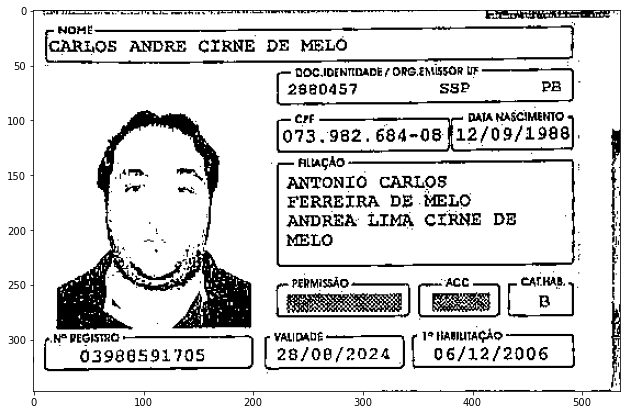

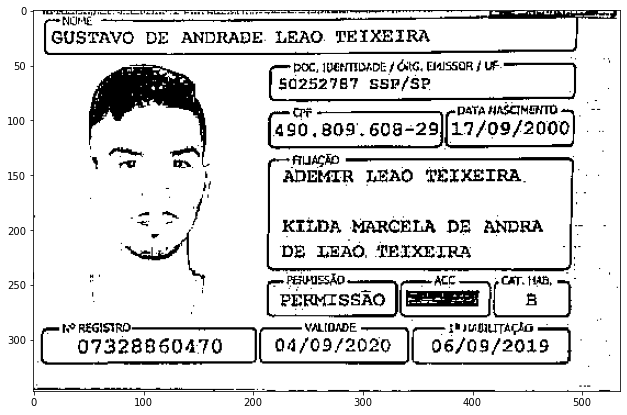

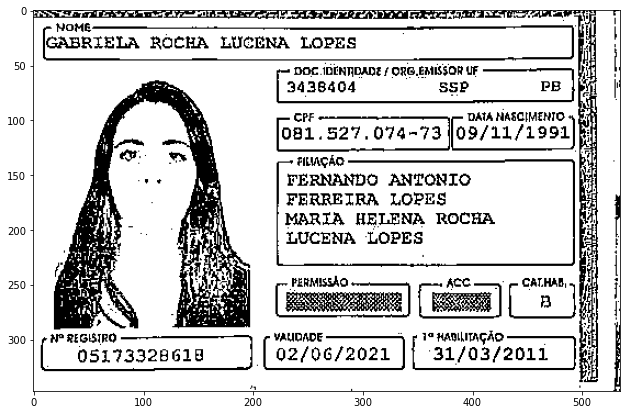

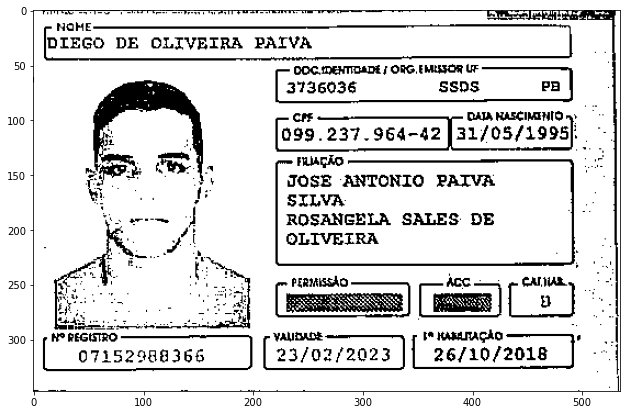

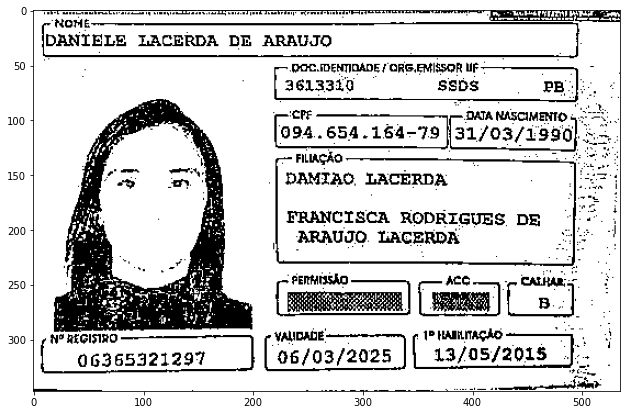

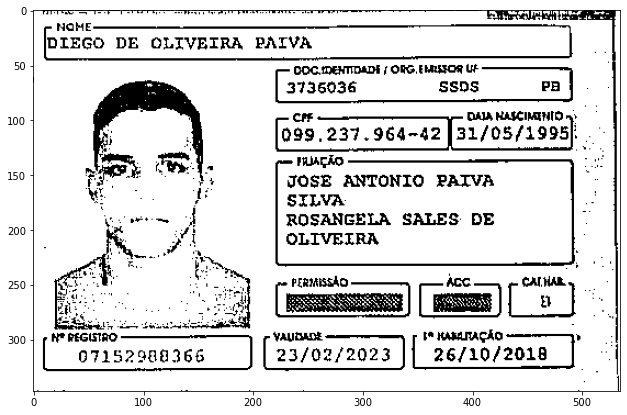

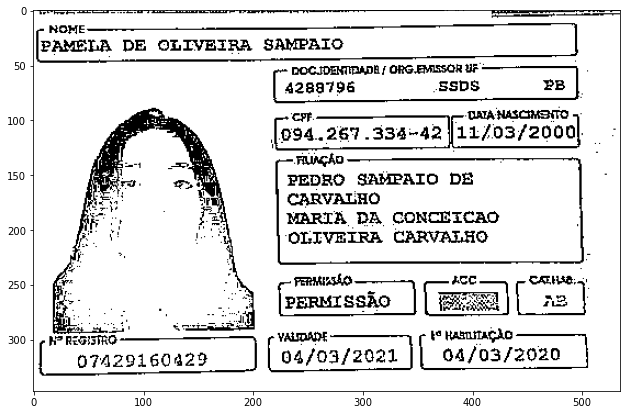

In [8]:
imgs = glob.glob("goodimages/*.jpeg")
imgReference = cv2.imread("goodimages/aligned.jpeg")

i = 0

for c in imgs:

    img = cv2.imread(c) 
    realinhada, h = sift_align(img, imgReference)
    crop = crop_image(realinhada)
    nitida = sharpenFunction(crop)
    filt = filterFunction(nitida)
    plt.imshow(cv2.cvtColor(filt, cv2.COLOR_BGR2RGB))
    plt.show()
    
    cv2.imwrite('processadas/ImagemNova%02i.jpg' %i, filt) 
    cv2.imwrite('alinhadas/ImagemNova%02i.jpg' %i, realinhada)
    i+=1